<a href="https://colab.research.google.com/github/JyothiMekalaa/Major-Project/blob/main/Major_Projectt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install opencv-python

In [3]:
pip install tensorflow keras

In [4]:
import os
import shutil
import itertools
import pathlib
from PIL import Image

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings('ignore')


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 5261 files belonging to 2 classes.
Shape of images array: (16, 224, 224, 3)


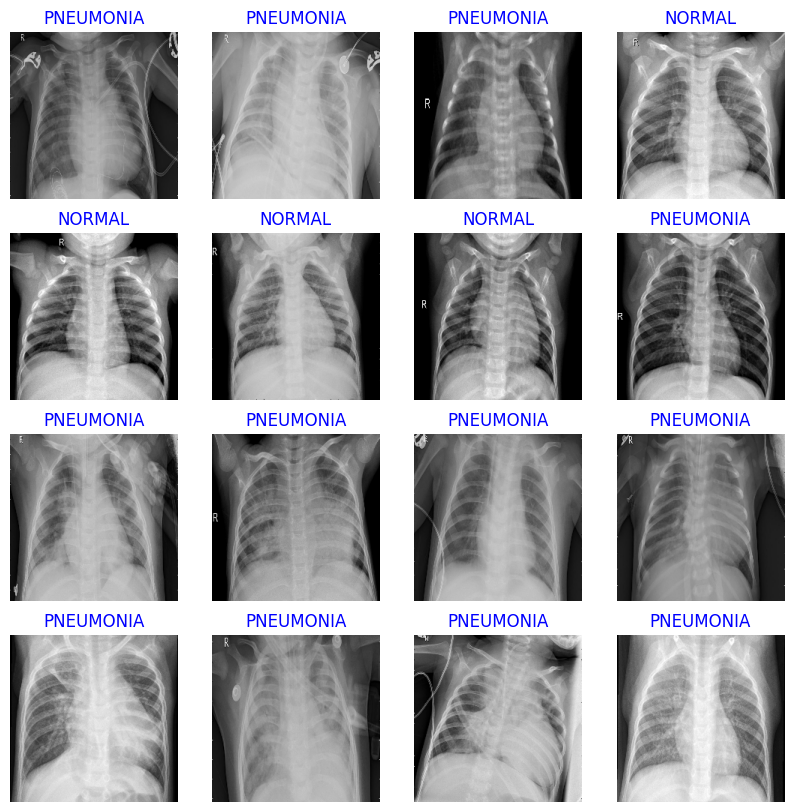

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory

training_data_path = '/content/drive/MyDrive/Dataset/chest_xray/train'


data_generator = image_dataset_from_directory(
    training_data_path,
    labels='inferred',
    label_mode='categorical',
    batch_size=16,
    image_size=(224, 224),
    color_mode='rgb'
)


class_names = data_generator.class_names


for images, labels in data_generator.take(1):
    print("Shape of images array:", images.shape)


    plt.figure(figsize=(10, 10))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        image = images[i].numpy().astype("uint8")
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = class_names[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')

    plt.show()

In [8]:
 from tensorflow.keras.preprocessing.image import ImageDataGenerator

 train_datagen = ImageDataGenerator(
 rescale=1./255,
 shear_range=0.2,
 horizontal_flip=True,
 zoom_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

 training_data = train_datagen.flow_from_directory(
     '/content/drive/MyDrive/Dataset/chest_xray/train',
  target_size=(224, 224),
  class_mode='binary',
  batch_size=32
)

 val_data = val_datagen.flow_from_directory(
     '/content/drive/MyDrive/Dataset/chest_xray/val',
     target_size=(224, 224),
     class_mode='binary',
     batch_size=32
     )

Found 5261 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


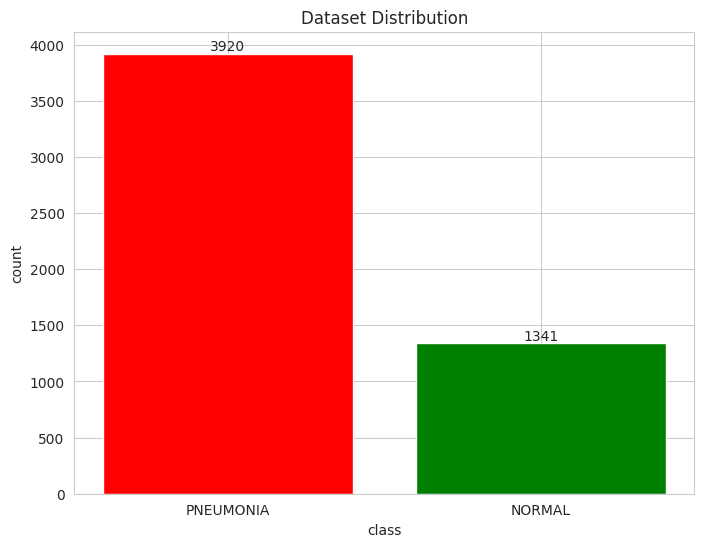

In [9]:
import os
import matplotlib.pyplot as plt

pneumonia_dataset_path = '/content/drive/MyDrive/Dataset/chest_xray/train'


if not os.path.exists(pneumonia_dataset_path):
    print(f"Error: The specified path '{pneumonia_dataset_path}' does not exist.")
else:

    pneumonia_images_path = os.path.join(pneumonia_dataset_path, 'PNEUMONIA')
    pneumonia_count = len(os.listdir(pneumonia_images_path))


    normal_images_path = os.path.join(pneumonia_dataset_path, 'NORMAL')
    normal_count = len(os.listdir(normal_images_path))

    labels = ['PNEUMONIA', 'NORMAL']
    counts = [pneumonia_count, normal_count]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(labels, counts, color=['red', 'green'])
    plt.xlabel('class')
    plt.ylabel('count')
    plt.title('Dataset Distribution')

    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width() / 2, count, str(count), ha='center', va='bottom')

    plt.show()

In [10]:
training_data.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

**VGG19**

In [11]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics
import matplotlib.pyplot as plt

In [12]:
IMAGE_SIZE = (224, 224)

vgg19 = VGG19(input_shape=IMAGE_SIZE + (3,), weights='imagenet', include_top=False)

for layer in vgg19.layers[-6:]:
    layer.trainable = True

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
x = Flatten()(vgg19.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
prediction = Dense(2, activation='softmax')(x)

In [18]:
model1 = Model(inputs=vgg19.inputs, outputs=vgg19.outputs)
model1.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model = Model(inputs=vgg19.inputs, outputs=prediction)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.00008),
              metrics=['accuracy',
                       metrics.Precision(name='precision_m'),
                       metrics.Recall(name='recall_m'),
                       metrics.AUC(name='auc_m'),
                       metrics.F1Score(name='f1_m')])


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


test_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dataset/chest_xray/train',
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dataset/chest_xray/test',
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='categorical'
)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)


hist = model.fit(
    train_set,
    validation_data=test_set,
    epochs=20,
    steps_per_epoch=len(train_set),
    validation_steps=len(test_set),
    callbacks=[learning_rate_reduction, early_stop])



Found 5261 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/20
  4/165 ━━━━━━━━━━━━━━━━━━━━ 3:31:11 79s/step - accuracy: 0.4733 - auc_m: 0.4768 - f1_m: 0.4277 - loss: 1.3118 - precision_m: 0.4733 - recall_m: 0.4733

KeyboardInterrupt: 

In [ ]:
vgg_acc = hist.history["accuracy"][-1]
vgg_prec = hist.history["precision_m"][-1]
vgg_rec = hist.history["recall_m"][-1]
vgg_f1 = hist.history["f1_m"][-1]

def storeResults(model_name, accuracy, precision, recall, f1_score):

    print(f"Results for {model_name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1_score.numpy().mean():.4f}") # Convert f1_score to NumPy array and take the mean for formatting

storeResults('VGG19', vgg_acc, vgg_prec, vgg_rec, vgg_f1)

Results for VGG19:
  Accuracy: 0.9093
  Precision: 0.9093
  Recall: 0.9093
  F1-score: 0.8840


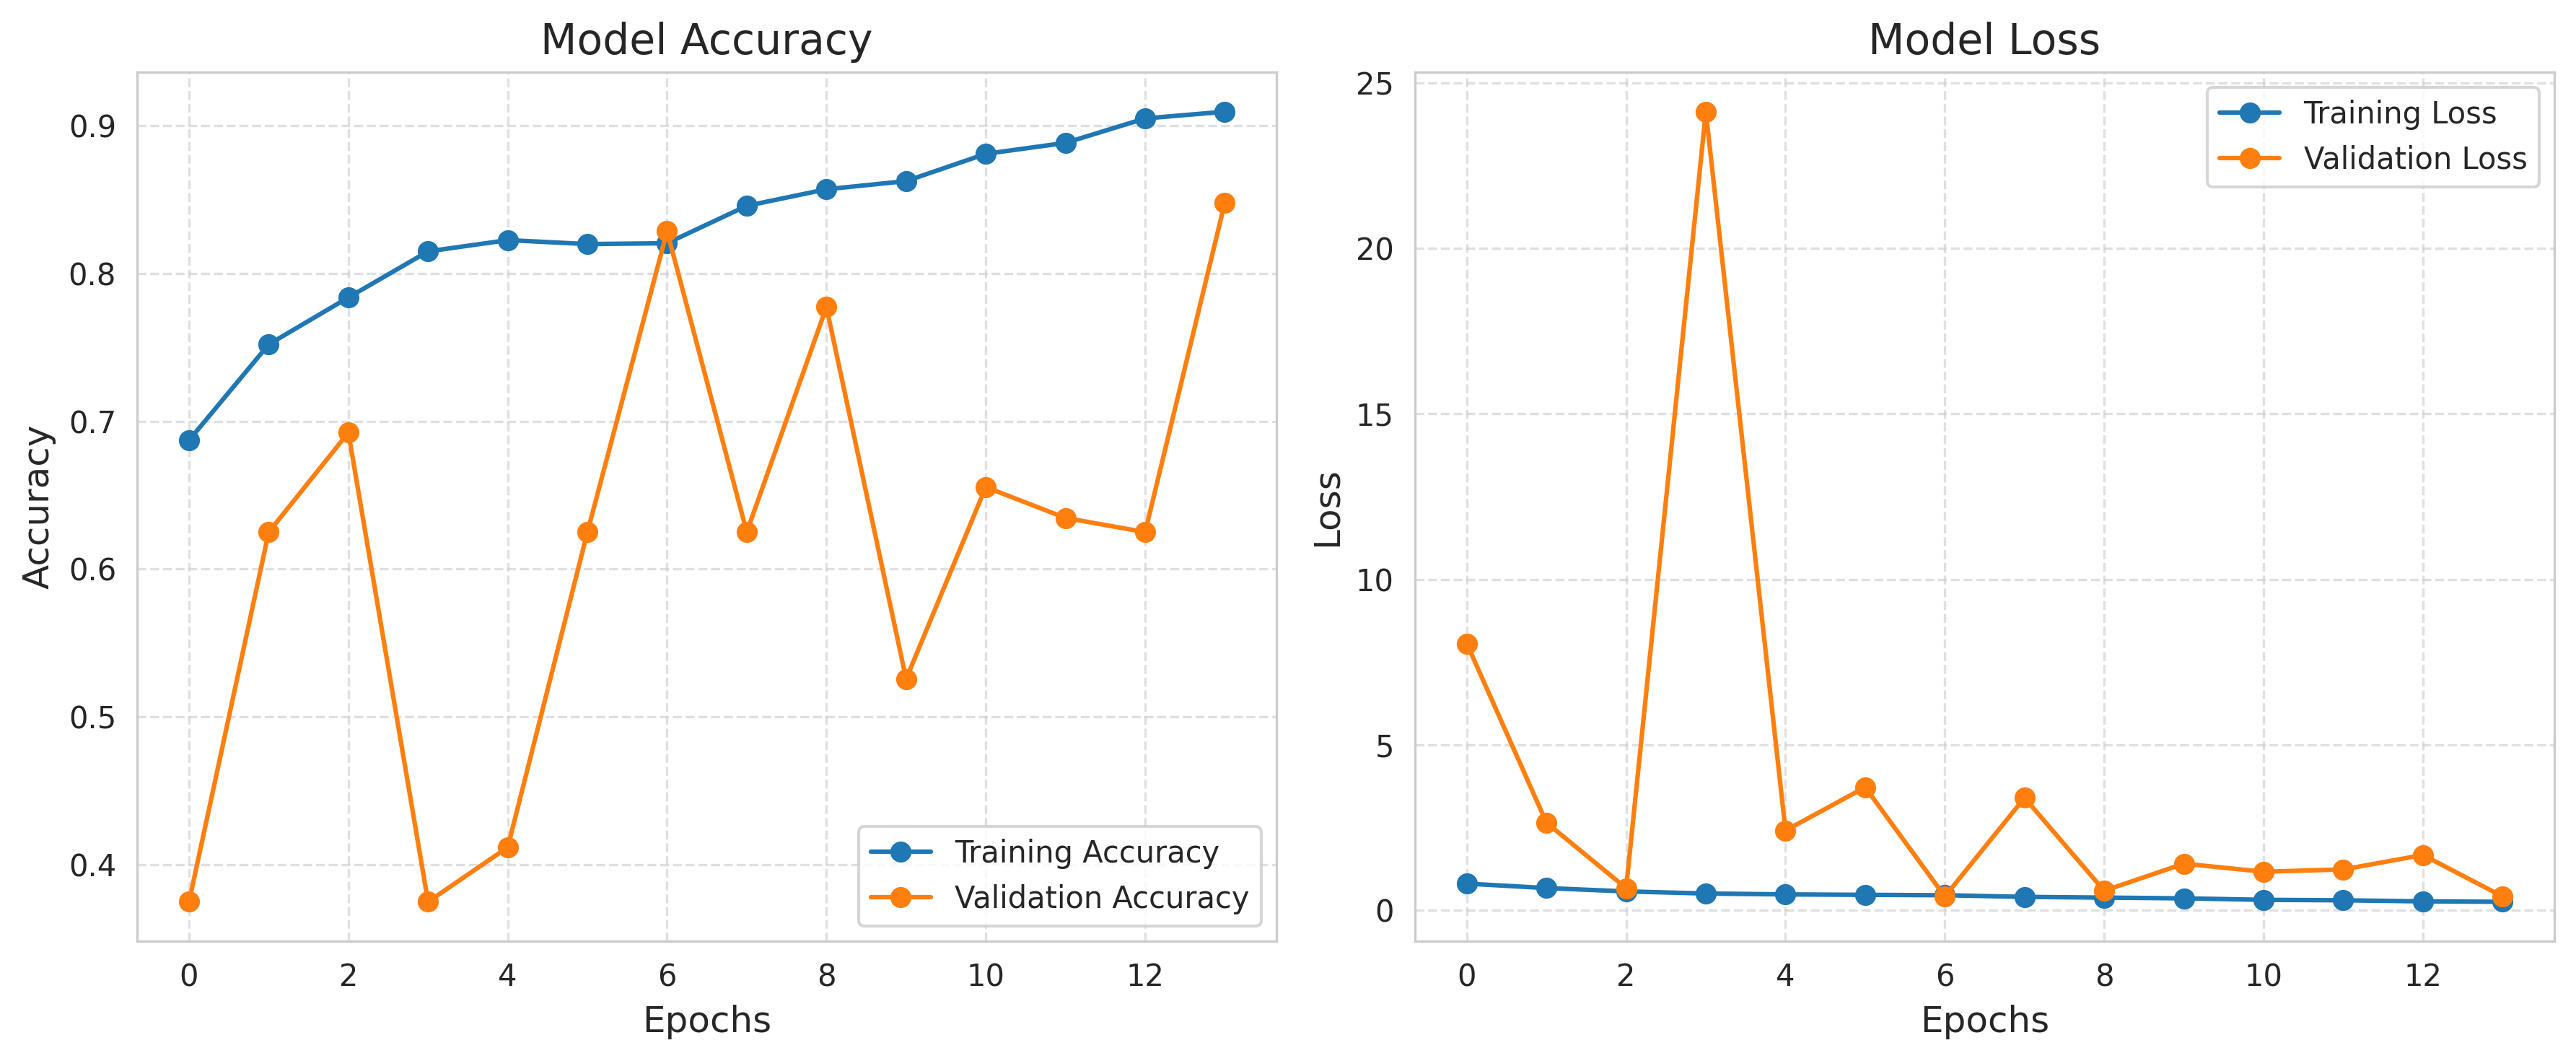

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5), dpi=300)

plt.subplot(1, 2, 1)
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.plot(hist.history['accuracy'], label='Training Accuracy', linestyle='-', marker='o')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy', linestyle='-', marker='o')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)


plt.subplot(1, 2, 2)
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.plot(hist.history['loss'], label='Training Loss', linestyle='-', marker='o')
plt.plot(hist.history['val_loss'], label='Validation Loss', linestyle='-', marker='o')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)


plt.tight_layout()
plt.show()


**ResNet101**

In [ ]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras import metrics
import matplotlib.pyplot as plt

In [ ]:
IMAGE_SIZE = (128, 128)

resnet101 = ResNet101(input_shape=IMAGE_SIZE + (3,), weights='imagenet', include_top=False)

for layer in resnet101.layers[-15:]:
    layer.trainable = True


In [ ]:
x = Flatten()(resnet101.output)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
prediction = Dense(2, activation='softmax')(x)

In [ ]:
prediction = Dense(2, activation='softmax')(x)
model1 = Model(inputs=resnet101.inputs, outputs=prediction)
model1.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 76,745,602 (292.76 MB)

 Trainable params: 76,637,186 (292.35 MB)

 Non-trainable params: 108,416 (423.50 KB)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=0.001, momentum=0.9),
              metrics=['accuracy',
                       metrics.AUC(name='auc_m'),
                       metrics.Precision(name='precision_m'),
                       metrics.Recall(name='recall_m')])

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dataset/chest_xray/train',
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dataset/chest_xray/test',
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='categorical'
)


learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=0.00001, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


hist = model.fit(
    train_set,
    validation_data=test_set,
    epochs=5,
    steps_per_epoch=len(train_set),
    validation_steps=len(test_set),
    callbacks=[learning_rate_reduction, early_stop]
)

model2 = Model(inputs=resnet101.inputs, outputs=prediction)

model2.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=0.001, momentum=0.9),
              metrics=['accuracy',
                       metrics.AUC(name='auc_m'),
                       metrics.Precision(name='precision_m'),
                       metrics.Recall(name='recall_m')])



hist = model2.fit(
    train_set,
    validation_data=test_set,
    epochs=5,
    steps_per_epoch=len(train_set),
    validation_steps=len(test_set),
    callbacks=[learning_rate_reduction, early_stop]
)


Found 5261 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/5


ValueError: Input 0 of layer "functional_3" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 128, 128, 3)

In [ ]:
resnet_acc = hist.history["accuracy"][-1]
resnet_prec = hist.history["precision_m"][-1]
resnet_rec = hist.history["recall_m"][-1]

try:
    resnet_f1 = hist.history["f1_m"][-1]
except KeyError:
    resnet_f1 = 0.0

def storeResults(model_name, accuracy, precision, recall, f1_score):
    print(f"Results for {model_name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1_score:.4f}")

storeResults('ResNet101', resnet_acc, resnet_prec, resnet_rec, resnet_f1)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5), dpi=300)

plt.subplot(1, 2, 1)
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.plot(hist.history['accuracy'], label='Training Accuracy', linestyle='-', marker='o')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy', linestyle='-', marker='o')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)


plt.subplot(1, 2, 2)
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.plot(hist.history['loss'], label='Training Loss', linestyle='-', marker='o', color='red')
plt.plot(hist.history['val_loss'], label='Validation Loss', linestyle='-', marker='o', color='blue')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)


plt.tight_layout()
plt.show()


**Comparision** **Metrics**

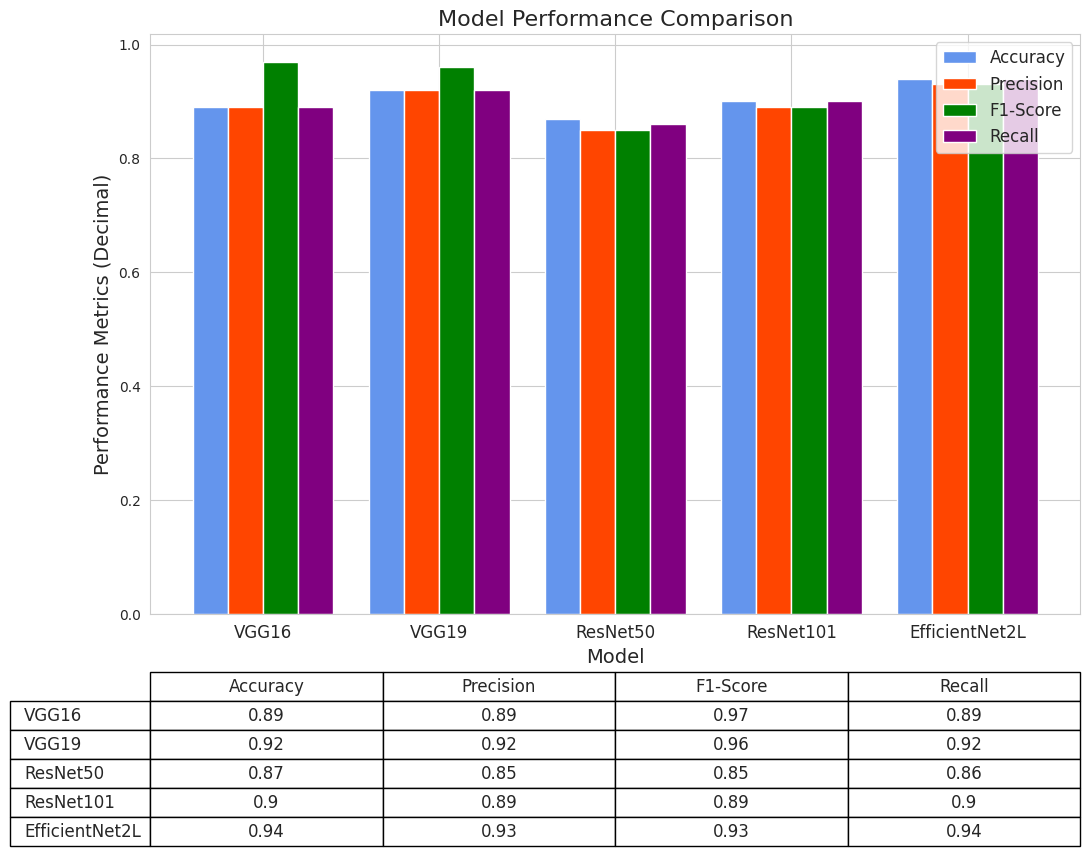

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

models = ["VGG16", "VGG19", "ResNet50", "ResNet101", "EfficientNet2L"]
accuracy = [0.89, 0.92, 0.87, 0.90, 0.94]
precision = [0.89, 0.92, 0.85, 0.89, 0.93]
f1_score = [0.97, 0.96, 0.85, 0.89, 0.93]
recall = [0.89, 0.92, 0.86, 0.90, 0.94]

x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 10))


ax.bar(x - 1.5 * width, accuracy, width, label="Accuracy", color="cornflowerblue")
ax.bar(x - 0.5 * width, precision, width, label="Precision", color="orangered")
ax.bar(x + 0.5 * width, f1_score, width, label="F1-Score", color="green")
ax.bar(x + 1.5 * width, recall, width, label="Recall", color="purple")


ax.set_ylabel("Performance Metrics (Decimal)", fontsize=14)
ax.set_xlabel("Model", fontsize=14)
ax.set_title("Model Performance Comparison", fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12)
ax.legend(fontsize=12)


data = np.array([accuracy, precision, f1_score, recall]).T
columns = ["Accuracy", "Precision", "F1-Score", "Recall"]
df = pd.DataFrame(data, index=models, columns=columns)


table = ax.table(cellText=df.round(3).values,
                 colLabels=df.columns,
                 rowLabels=df.index,
                 cellLoc='center',
                 loc='bottom',
                 bbox=[0, -0.4, 1, 0.3])


table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.5, 1.5)

plt.subplots_adjust(bottom=0.3)

plt.savefig("model_performance_decimal.png", bbox_inches='tight', dpi=300)

plt.show()
